# MULTICLASS CLASSIFICATION OF ONLINE ARTICLES


## **CODE PART 3** of the case study on using NLP techniques alongside with Machine Learning Alrorithms to classify news into categories



## MODELS COMPARISON




### CASES OF COMPARISION

In this notebook we will compare the results from all models for all cases.\
There is **2  cases** :
and other on balanced data:


*   **CASE 1 : TOTAL IMBALANCED DATASET**

*   **CASE 2 : UNDER SAMPLED BALANCED DATATSET**







### METRICS 


In the comparison of the Models we will use metrics scores, well known like :
* **accuracy** : The simplest way to evaluate a model, but not reliable.\

So we use other metrics present in the **Confusion Matrix** like **precision** and **recall**, we combine them to one score :
* **f1 score** A repectible score that take i count all correct and incorrect predictions.
The f1 score will be calculted in two forms **macro averaged f1 score** and **mico averaged f1 score**
** **micro averaged f1 score** : indicates the classifier performence for each individual class. it is more suitable for data with an imbalanced class distribution.
** **micro averaged f1 score** : indicates the performence overall, can be particularly misleading when the class distribution is imbalanced.


And also the score of reliablity of the model:
* **kappa** to mesure the agreement between our classifier and the true classification, the bigger the agreement the more reliable the classifier.


## LOADING DATASET AND RESULT OF MODELS




The models predictions are been saved for each model, alongside with and the datasets for the 2  cases in the our Google drive in form of csv. So first we need to get the files.

We will use the resulting prediction from our models to be the indicator of the performance.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


### LOAD DATASETS FOR ALL 2 CASES

We also load the datasets for each case.

In [ ]:
 !mkdir DATASETS

# Download DATASET CASE 1
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
cases_file_id = '1Rb6mp-1U8HtYBK-A3vrTlBkzFT76u9cV' #-- Updated File ID for my zip
f = drive.CreateFile({'id': cases_file_id})
f.GetContentFile('DATASETS/case_1_dataset.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString(encoding='cp862')))

mkdir: cannot create directory ‘DATASETS’: File exists


In [ ]:

# Download DATASET CASE 2
#
cases_file_id = '1IaR7YFEk4NokLdDQZdL81K0484CR2aTj' #-- Updated File ID for my zip
f = drive.CreateFile({'id': cases_file_id})
f.GetContentFile('DATASETS/case_2_dataset.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString(encoding='cp862')))

### LOAD ALL RESULTS



In [ ]:

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
cases_file_id = '1r3WZHFDSdV3C0XNFnKQxtIyuEqX5edzV' #-- Updated File ID for my zip
downloaded = drive.CreateFile({'id': cases_file_id})
downloaded.GetContentFile('models_pred.zip')
#print('Downloaded content "{}"'.format(downloaded.GetContentString(encoding='cp862')))

In [ ]:
! unzip models_pred.zip

Archive:  models_pred.zip
replace CASE_1/pred_class_case_1_split_1_nb.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### IMPORT NECESSARY LABRARIES



In [ ]:
!pip install seaborn==0.11.0


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import cohen_kappa_score


## DEFINE NECESSARY FUNCTIONS



In [ ]:
def get_dataset_count(dataset):
  category_count = dataset['category'].value_counts()
  category_count = category_count.to_frame()
  category_count['class'] = category_count.index
  category_count.rename(columns={'category':'counts'}, inplace=True)
  return category_count

In [ ]:
def get_scores_table(model_results):
    results = pd.read_csv(model_results)
    results = results[['pred', 'true']]

    micro_averages = [ x if isinstance(x, float) else x for x in precision_recall_fscore_support(results.pred, results.true, average='micro') ]

    Kappa = [cohen_kappa_score(results.pred, results.true)]*3
    report = classification_report(results.pred, results.true, output_dict=True)
    report = pd.DataFrame(report).transpose()

    report.loc['micro avg'] = micro_averages
    report.loc['kappa'] = [cohen_kappa_score(results.pred, results.true)]*4
    report['class'] = report.index
    
    return report

In [ ]:
def plot_score(report, x, y, srt, out):
    if out >0:
      report = report[:-out]
    plt.figure(figsize=(16, 6))

    g = sns.barplot(x=x, y=y, data=report.sort_values(by=srt), palette = 'Set2')
    g.set_xticklabels(g.get_xticklabels(), rotation=90, )

In [ ]:
def add_counts(result, counts):
    result['counts'] = counts['counts']
    return result

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_pairs_value(result_full):

    p = sns.relplot(x= 'counts', y='f1-score', hue='class', data=result_full[:-5].sort_values(by='counts'), 
                palette='Paired_r', height=12,
                sizes= result_full['counts'][:-5].sort_values() );

    ax = p.axes[0,0]
    for idx,row in result_full[:-5].iterrows():
        x = row[5]
        y = row[2]
        text = row[4]
        ax.text(x+.05,y,text, horizontalalignment='left', rotation=45)
    plt.show()

In [ ]:
def add_model(case, result, rows, model):
    result_new = result[-rows:].copy()
    result_new['model'] = [model]*result_new.shape[0]
    return case.append(result_new)

In [ ]:
def add_model_to_case(case, result, out, model):
    result_new = result[-out:].transpose()
    result_new['model'] = model
    result_new = result_new[:1].reset_index(drop=True)

    return case.append(result_new)

# CASE 1 : IMBALANCED DATA


In the dataset there is more than 200k subjects, and as we do the classification using the **category** colums, we found as we see a big imbalance toward some categories.\
In this part we will compare the performence of the models, using all this dataset. Without touching on the imbalance.


In the case of imbalanced data, like this case it is preferable to use **macro averaging f1 score** score, to get to see how the model has handeled each class even the smaller ones. The **mico averaging f1score** will indicate the performence of the model overall.

It depend on how much we care about the each class. If we care about reach class equaly, and we want them all the be well classed, we may care more about the **macro score**. But if we care in favore of the score overall and we may tolerate the poor classification of the minor classes, we may take the **micro score**.


We save these result to dataframe to later manipulations


## DATASET CASE 1


In [ ]:
case_1_dataset = pd.read_csv('DATASETS/case_1_dataset.csv')
print(case_1_dataset.columns)
case_1_data_set_count = get_dataset_count(case_1_dataset)
case_1_data_set_count



Index(['Unnamed: 0', 'category', 'information', 'label'], dtype='object')


,counts,class
POLITICS,32739,POLITICS
ENTERTAINMENT,21233,ENTERTAINMENT
WELLNESS,17827,WELLNESS
PARENTS,12632,PARENTS
STYLE & BEAUTY,11903,STYLE & BEAUTY
TRAVEL,9887,TRAVEL
WORLD NEWS,8420,WORLD NEWS
FOOD & DRINK,8322,FOOD & DRINK
HEALTHY LIVING,6694,HEALTHY LIVING
QUEER VOICES,6314,QUEER VOICES


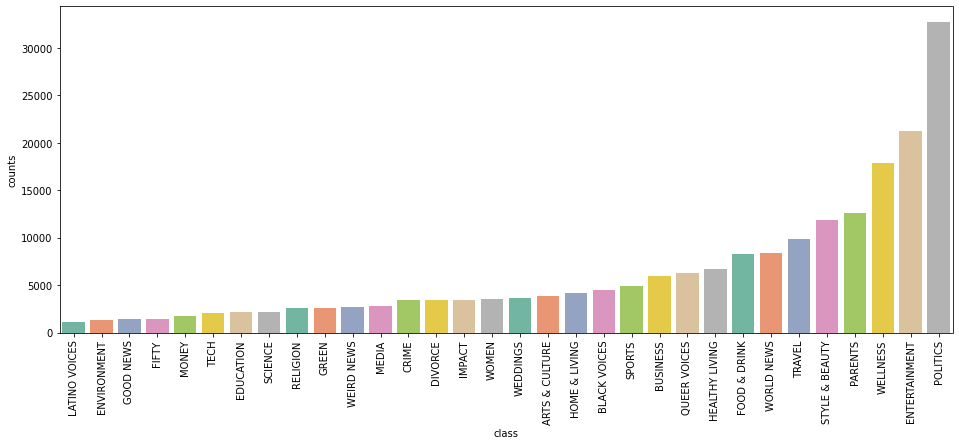

In [ ]:
plot_score(case_1_data_set_count, 'class', 'counts', 'counts', 0)



We can see that our dataset for the 1 case, has 32 **category** and thers is a really big imballance in the categories, witch the ellement weill class based on it. We will see how the models will perform with this big imbalance in the dataset.

## LOGISTIC REGRESSION


We load the resul for the **logistic regression model**, then we will proced with the analysis.

In [ ]:
case_1_result_log_reg = get_scores_table('CASE_1/pred_class_case_1_split_1_reg_log.csv')

In [ ]:
case_1_result_log_reg

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.462687,0.569730,0.510659,925.000000,ARTS & CULTURE
BLACK VOICES,0.393119,0.504225,0.441794,1065.000000,BLACK VOICES
BUSINESS,0.468347,0.484357,0.476218,1726.000000,BUSINESS
CRIME,0.527255,0.573276,0.549303,928.000000,CRIME
DIVORCE,0.692898,0.818594,0.750520,882.000000,DIVORCE
EDUCATION,0.383148,0.467054,0.420961,516.000000,EDUCATION
ENTERTAINMENT,0.753778,0.610870,0.674841,7838.000000,ENTERTAINMENT
ENVIRONMENT,0.289003,0.582474,0.386325,194.000000,ENVIRONMENT
FIFTY,0.183575,0.331878,0.236392,229.000000,FIFTY
FOOD & DRINK,0.779794,0.732946,0.755644,2580.000000,FOOD & DRINK


The score are in the last 5 rows in the dataset, we put all result in one dataset, so we don't have ot write a lot of code after


#### GENERAL VIEW

We gonna first look at the general scores of the models, like **accuracy, f1 score, and kappa** for the general score.


From we can see, ther is a lot of trends, we can see that we get a **accuracy** of **64** that it not that good, but not all bad.

For that score we generally assum lower **f1 score**, but got also **value from 53 to 65**. witch is good.



We have 3 values of **f1 score** for **macro, micro, and weighted averages**.

The f1 score is the most praised score in quality of classifcation, In the case of multiclasses, we can get different value depanding on how we combine them. Whe know that **macro averaging**  will compute the metric
independently for each class and then take the average so it treat all classes equally. So if the model didn't classify the all classes well, it will get  low f1 score, the **micro f1 score** will give favourase the bigger classes, so if we classsify them well we will get a hight **f1 score**.

One important aspect is is dataset is that it's imbalanced, so if the models is supposed to claasify bigger classes well, as it has more data, hunce should have bigger **f1 score for micro averaging**, and well this true for the case as we got **64**. The contrary happen in the **macro score** where we got only **53** witch mean that our model tend to bias toward bigger classes, but we don't really know yet for sure. with further analysis we will analyse this prediction.

Now let's see if our model is **reliable**, using the **kappa** score, who calculate the aggrement between the model prediction and real classification, the bigger the score the more reliable hence, **performent** the module. In our we get a value of exactelly 60.087 round it to **61** with mean it get a **Substantial** score according to kappa scoring. and that mean the model is good.

#### INSIDER VIEW

We add the count by categories to our result dataframe so we case our the frequency by class afect the classification

In [ ]:

#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_1_result_log_reg['counts'] = case_1_data_set_count['counts']
case_1_result_log_reg

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.462687,0.569730,0.510659,925.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.393119,0.504225,0.441794,1065.000000,BLACK VOICES,4528.0
BUSINESS,0.468347,0.484357,0.476218,1726.000000,BUSINESS,5937.0
CRIME,0.527255,0.573276,0.549303,928.000000,CRIME,3405.0
DIVORCE,0.692898,0.818594,0.750520,882.000000,DIVORCE,3426.0
EDUCATION,0.383148,0.467054,0.420961,516.000000,EDUCATION,2148.0
ENTERTAINMENT,0.753778,0.610870,0.674841,7838.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.289003,0.582474,0.386325,194.000000,ENVIRONMENT,1323.0
FIFTY,0.183575,0.331878,0.236392,229.000000,FIFTY,1401.0
FOOD & DRINK,0.779794,0.732946,0.755644,2580.000000,FOOD & DRINK,8322.0


Let's see if there is a correlation between the size of the class and it's **f1 score** of each class

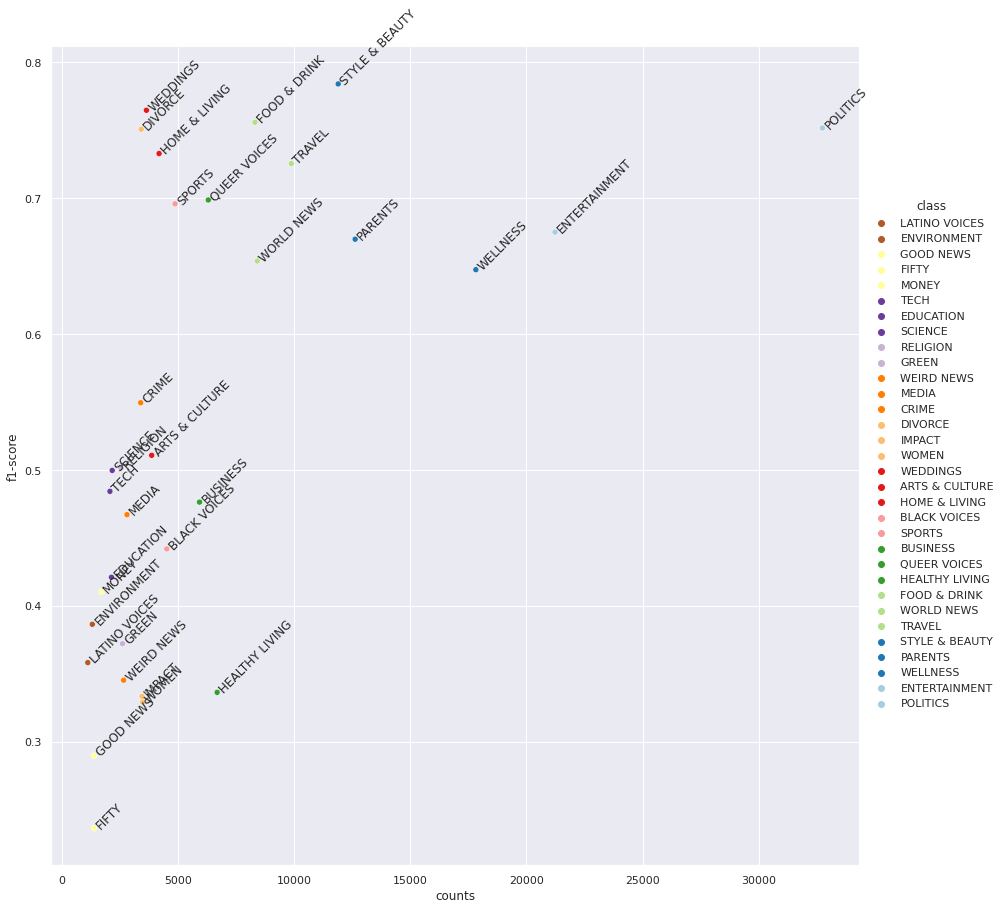

In [ ]:

plot_pairs_value(case_1_result_log_reg)

As we can see there is an average correlation, but not something we can build on an generalisation. In general the very small classes get low f1 score, the bigger the class the score get a bit bigger. But most of the classes are small compared to some outlayer classes like **Politics, Entertanement and Wellnes**

Even though we can see some clustering hapeining at the scater of the points. There is 2 to 3 groups of clusters. For the 2 groups, the big difference is in f1 score. Group 1 is under 0.56. An the other is below 0.65. I's ineresting that the size of the classter didn't play a role in the good score those claster got.

But I can theorise by looking the class memner differences.


*   In the lower group the class tend to have shallow deffinition. Like **Good News** and **Weird News**,   at the end both are new and a good news can be weird also. Same case with **Tech** and **Science** may intertcollid, cause tech involve a lot time science and vis versa. In the case of **Envirement** and **Green** can represent same class, so maybe it's better to merge them in one class. So some of this class are not well classified is beacuse it collide with other class, or may represente same thing.
*   In the upper group class are well deffined and clear and **specific** in what they represent. Like **Sport**, **Divorce**, **Politics**, those cannot intercollinde with each other. And dp not represent same thing, the model can easay indentify them.




In [ ]:
case_1_result_log_reg[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,0.548082
counts,0.548082,1.000000


From the correlation we can see that model has the same average values around **55**. Mean that the size of the class is partially correlated with it's f1 score.


## NAIVE BAYES



We load the resul for the **naive bayes model**, then we will proced with the analysis.

In [ ]:
case_1_result_nb = get_scores_table('CASE_1/pred_class_case_1_split_1_nb.csv')

In [ ]:
case_1_result_nb

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.250219,0.738342,0.373770,386.000000,ARTS & CULTURE
BLACK VOICES,0.177160,0.611111,0.274688,396.000000,BLACK VOICES
BUSINESS,0.393277,0.506494,0.442763,1386.000000,BUSINESS
CRIME,0.494549,0.607056,0.545057,822.000000,CRIME
DIVORCE,0.463532,0.856383,0.601494,564.000000,DIVORCE
EDUCATION,0.108108,0.581197,0.182306,117.000000,EDUCATION
ENTERTAINMENT,0.762280,0.562565,0.647369,8607.000000,ENTERTAINMENT
ENVIRONMENT,0.084399,0.868421,0.153846,38.000000,ENVIRONMENT
FIFTY,0.004831,0.666667,0.009592,3.000000,FIFTY
FOOD & DRINK,0.783918,0.745198,0.764068,2551.000000,FOOD & DRINK


#### GENERAL VIEW

We see that in general, that naive bayes got lwer scores that, logistic trgression. In all scores. the accuracy is **60**, but the **f1 score** is lowe a lot esspecially in **maco average** where it got only **40**, but in the **mirco** it got **60**, an average value , not really bad, but it's slitly, low compared to logistic regression .that mean it have low score in there a lot small classes, we will see in the ploting. 

Also kappa score is alos low at **0.56** wicth it means the model has a **moderate** reliability.  

#### INSIDER VIEW

In [ ]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_1_result_nb['counts'] = case_1_data_set_count['counts']
case_1_result_nb

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.250219,0.738342,0.373770,386.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.177160,0.611111,0.274688,396.000000,BLACK VOICES,4528.0
BUSINESS,0.393277,0.506494,0.442763,1386.000000,BUSINESS,5937.0
CRIME,0.494549,0.607056,0.545057,822.000000,CRIME,3405.0
DIVORCE,0.463532,0.856383,0.601494,564.000000,DIVORCE,3426.0
EDUCATION,0.108108,0.581197,0.182306,117.000000,EDUCATION,2148.0
ENTERTAINMENT,0.762280,0.562565,0.647369,8607.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.084399,0.868421,0.153846,38.000000,ENVIRONMENT,1323.0
FIFTY,0.004831,0.666667,0.009592,3.000000,FIFTY,1401.0
FOOD & DRINK,0.783918,0.745198,0.764068,2551.000000,FOOD & DRINK,8322.0


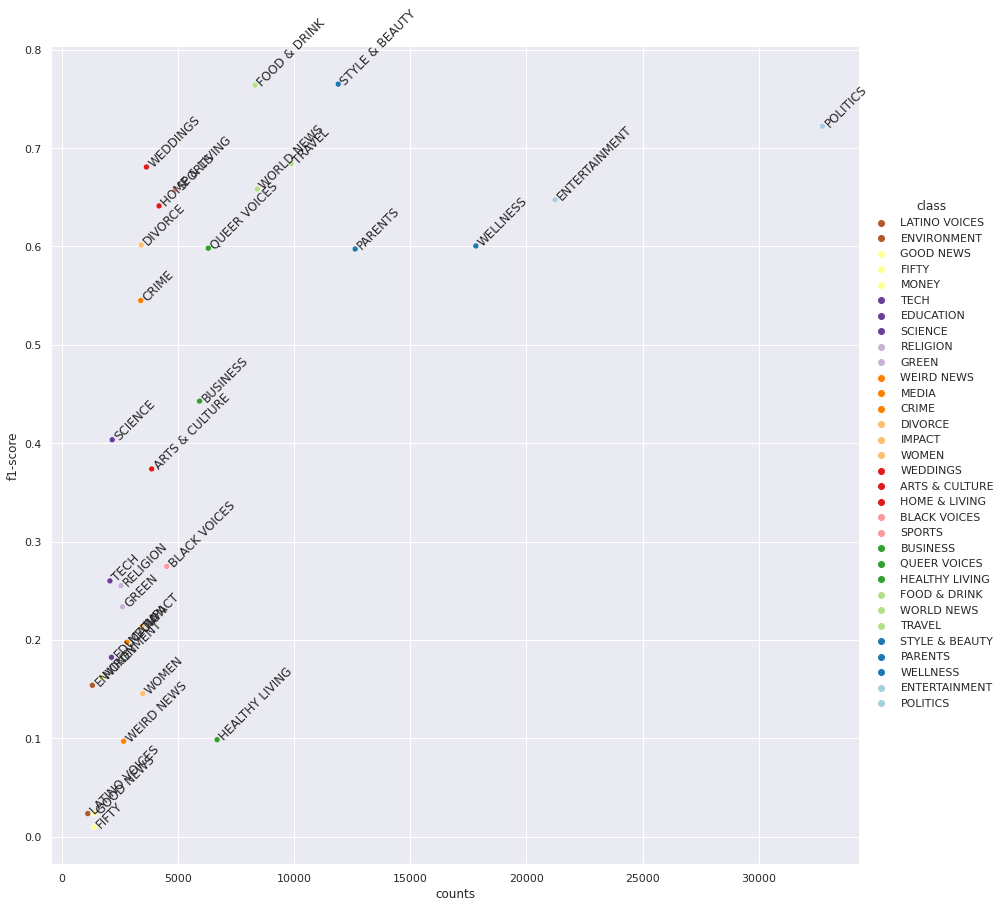

In [ ]:

plot_pairs_value(case_1_result_nb)

For the analysis of the graph, it has the same characteristic of the graph of th logistic regression, there are some emerging groups. The scatter of the classes are abit different but the general trend is still spresent. the **shallow** classes with low score, and the **clear** classes with good score.

In [ ]:
case_1_result_nb[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,0.591007
counts,0.591007,1.000000


The naive bayse have better correlation between it's classification and the size of the classes. Still not substantial one, but it;s better that Logistic Regression.


## SUPPORT VECTOR MACHINES



We load the resul for the **support vector machine model**, then we will proced with the analysis.

In [ ]:
case_1_result_svm = get_scores_table('CASE_1/pred_class_case_1_split_1_svm.csv')

In [ ]:
case_1_result_svm

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.422300,0.492323,0.454631,977.000000,ARTS & CULTURE
BLACK VOICES,0.383602,0.419872,0.400918,1248.000000,BLACK VOICES
BUSINESS,0.400000,0.407534,0.403732,1752.000000,BUSINESS
CRIME,0.489594,0.492032,0.490810,1004.000000,CRIME
DIVORCE,0.689060,0.737166,0.712302,974.000000,DIVORCE
EDUCATION,0.332273,0.337097,0.334668,620.000000,EDUCATION
ENTERTAINMENT,0.672387,0.629013,0.649977,6790.000000,ENTERTAINMENT
ENVIRONMENT,0.258312,0.397638,0.313178,254.000000,ENVIRONMENT
FIFTY,0.202899,0.235955,0.218182,356.000000,FIFTY
FOOD & DRINK,0.740206,0.699532,0.719295,2566.000000,FOOD & DRINK


#### GENERAL VIEW

We see that in general, that svm got lower scores that, logistic trgression. But better a bit brom naive bays in all scores. the accuracy is **60**, but the **f1 score macro** got **48** better that naive bayse, but less than logistic regression. Still a big gape between it and **micro f1 score**, so the small classes are also not well classes.

Also kappa score is also low  like naive bayse at **0.56** wicth it means the model has a **moderate** reliability.  

#### INSIDER VIEW

In [ ]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_1_result_svm['counts'] = case_1_data_set_count['counts']
case_1_result_svm

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.422300,0.492323,0.454631,977.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.383602,0.419872,0.400918,1248.000000,BLACK VOICES,4528.0
BUSINESS,0.400000,0.407534,0.403732,1752.000000,BUSINESS,5937.0
CRIME,0.489594,0.492032,0.490810,1004.000000,CRIME,3405.0
DIVORCE,0.689060,0.737166,0.712302,974.000000,DIVORCE,3426.0
EDUCATION,0.332273,0.337097,0.334668,620.000000,EDUCATION,2148.0
ENTERTAINMENT,0.672387,0.629013,0.649977,6790.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.258312,0.397638,0.313178,254.000000,ENVIRONMENT,1323.0
FIFTY,0.202899,0.235955,0.218182,356.000000,FIFTY,1401.0
FOOD & DRINK,0.740206,0.699532,0.719295,2566.000000,FOOD & DRINK,8322.0


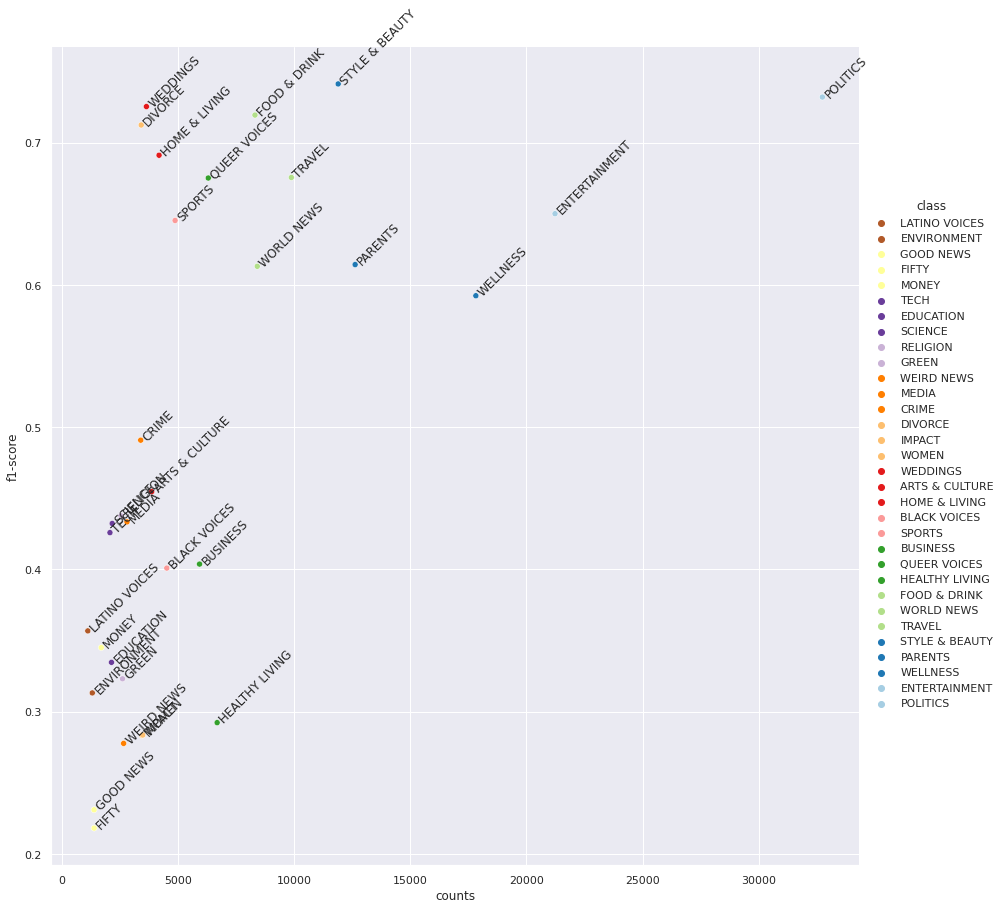

In [ ]:

plot_pairs_value(case_1_result_svm)


We still have two distinct groups and even clearer. The size of the class didn't play a the critical role in the classification performance for the classes, because it exists small groups with good scores.

*   Upper Group: still the same from other models. It contains classes with clear and foced identity. 
*   lower Group: same like in the other models. It contains small classes, and these class tend to have a vaste indentity, and even intersect with other classes or have same meaning.

But it clear that the bigger classes, lie **politics, Wellness, Entertainement ..** are well classed and the smallest classes, like **Fifty, good News, women** are not well classed, so the size also play a role in this case.


In [ ]:
case_1_result_svm[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,0.566679
counts,0.566679,1.000000


We have the same correlation like some other model, we can say that the size play a role in the quality of the classification, but not a critical role. There are other variable related to the identity of same classes.



## RANDOM FORRET



We load the resul for the **random forrest model**, then we will proced with the analysis.

In [ ]:
case_1_result_rf = get_scores_table('CASE_1/pred_class_case_1_split_1_rf.csv')

In [ ]:
case_1_result_rf

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.311677,0.572581,0.403638,620.000000,ARTS & CULTURE
BLACK VOICES,0.215959,0.553471,0.310690,533.000000,BLACK VOICES
BUSINESS,0.374790,0.445406,0.407058,1502.000000,BUSINESS
CRIME,0.443013,0.492291,0.466354,908.000000,CRIME
DIVORCE,0.597889,0.846467,0.700787,736.000000,DIVORCE
EDUCATION,0.346582,0.406716,0.374249,536.000000,EDUCATION
ENTERTAINMENT,0.721033,0.476934,0.574115,9603.000000,ENTERTAINMENT
ENVIRONMENT,0.107417,0.954545,0.193103,44.000000,ENVIRONMENT
FIFTY,0.048309,0.392157,0.086022,51.000000,FIFTY
FOOD & DRINK,0.757938,0.614305,0.678604,2992.000000,FOOD & DRINK


#### GENERAL VIEW

The random forrest have a result near those from naive bayse, but with minor variation, the trick is that is model took a long time to train. Longer that most of them, but manage to get lower values from logistic regression.

Also kappa score is also low at **0.54** wicth it means the model has a **moderate** reliability.  

In general we can not recomand this model, at least for the time it takes to train.


#### INSIDER VIEW

In [ ]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_1_result_rf['counts'] = case_1_data_set_count['counts']
case_1_result_rf

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.311677,0.572581,0.403638,620.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.215959,0.553471,0.310690,533.000000,BLACK VOICES,4528.0
BUSINESS,0.374790,0.445406,0.407058,1502.000000,BUSINESS,5937.0
CRIME,0.443013,0.492291,0.466354,908.000000,CRIME,3405.0
DIVORCE,0.597889,0.846467,0.700787,736.000000,DIVORCE,3426.0
EDUCATION,0.346582,0.406716,0.374249,536.000000,EDUCATION,2148.0
ENTERTAINMENT,0.721033,0.476934,0.574115,9603.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.107417,0.954545,0.193103,44.000000,ENVIRONMENT,1323.0
FIFTY,0.048309,0.392157,0.086022,51.000000,FIFTY,1401.0
FOOD & DRINK,0.757938,0.614305,0.678604,2992.000000,FOOD & DRINK,8322.0


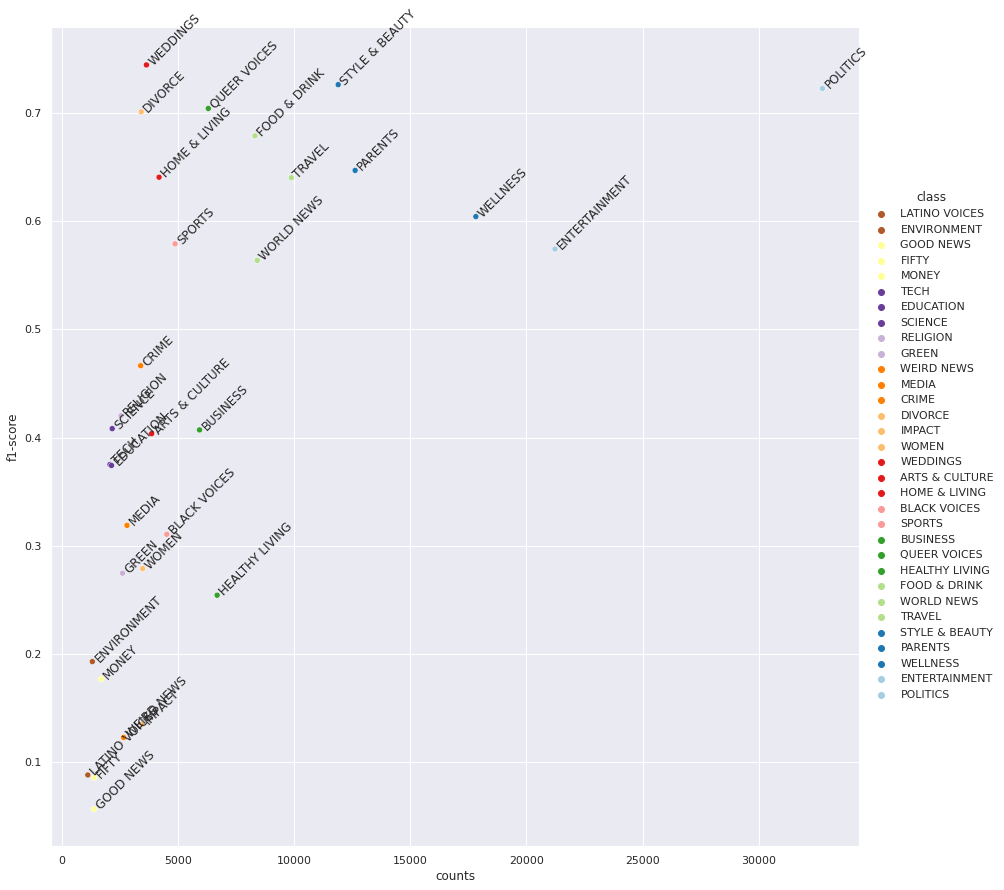

In [ ]:

plot_pairs_value(case_1_result_rf)


It's the same trend, we don't have anything to add. there stil the same class, and the size still have a moderate role in total classification.

In [ ]:
case_1_result_rf[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,0.558933
counts,0.558933,1.000000


We have the same correlation like some other model, we can say that the size play a role in the quality of the classification, but not a critical role. There are other variable related to the identity of same classes.


## BERT




We load the resul for the **naive bayes model**, then we will proced with the analysis.

In [ ]:
case_1_result_bert = get_scores_table('CASE_1/pred_class_case_1_split_2_bert.csv')

In [ ]:
case_1_result_bert

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.548291,0.461732,0.501302,4377.000000,ARTS & CULTURE
BLACK VOICES,0.322331,0.510378,0.395122,2698.000000,BLACK VOICES
BUSINESS,0.545827,0.469678,0.504898,6530.000000,BUSINESS
CRIME,0.590699,0.575976,0.583245,3330.000000,CRIME
DIVORCE,0.749692,0.809049,0.778240,3006.000000,DIVORCE
EDUCATION,0.555500,0.476818,0.513161,2351.000000,EDUCATION
ENTERTAINMENT,0.745592,0.672967,0.707421,22432.000000,ENTERTAINMENT
ENVIRONMENT,0.029412,0.381443,0.054613,97.000000,ENVIRONMENT
FIFTY,0.009782,0.342105,0.019020,38.000000,FIFTY
FOOD & DRINK,0.818009,0.799703,0.808753,8088.000000,FOOD & DRINK


#### GENERAL VIEW

BERT tend to have better than all models we have, got **accuracy** of **0.67** and **macro f1 score** of **0.53** like logistic regression, but for **micro** we got **0.67**, the best till now. There still a big gap between the mocro and macro values. Bit in general those value are moderete if we want t count on the model in real production envirement. Th

Also kappa score is alos low at **0.64** wicth it means the model **substantial** reliability, and it's the best aong all the models.


#### INSIDER VIEW

In [ ]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_1_result_bert['counts'] = case_1_data_set_count['counts']
case_1_result_bert

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.548291,0.461732,0.501302,4377.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.322331,0.510378,0.395122,2698.000000,BLACK VOICES,4528.0
BUSINESS,0.545827,0.469678,0.504898,6530.000000,BUSINESS,5937.0
CRIME,0.590699,0.575976,0.583245,3330.000000,CRIME,3405.0
DIVORCE,0.749692,0.809049,0.778240,3006.000000,DIVORCE,3426.0
EDUCATION,0.555500,0.476818,0.513161,2351.000000,EDUCATION,2148.0
ENTERTAINMENT,0.745592,0.672967,0.707421,22432.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.029412,0.381443,0.054613,97.000000,ENVIRONMENT,1323.0
FIFTY,0.009782,0.342105,0.019020,38.000000,FIFTY,1401.0
FOOD & DRINK,0.818009,0.799703,0.808753,8088.000000,FOOD & DRINK,8322.0


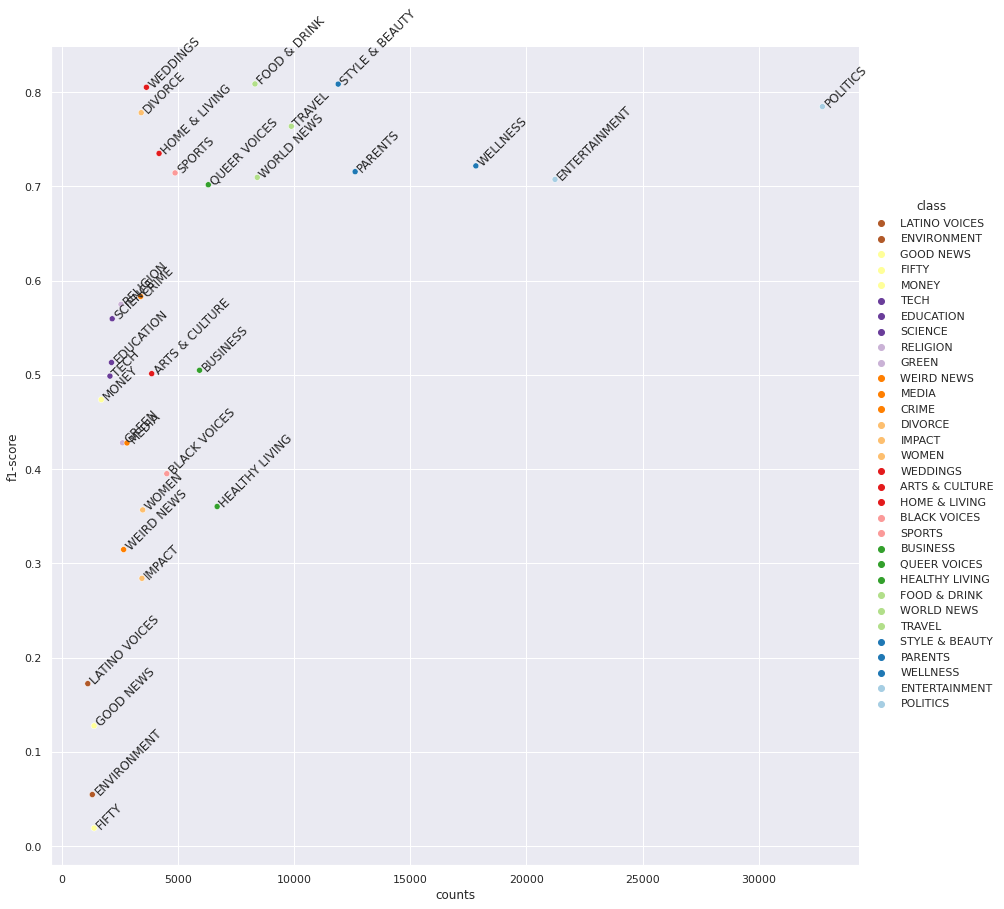

In [ ]:

#plot.savefig("case_1_result_bert.png")
#plot

plot_pairs_value(case_1_result_bert)


In bert we can see the emergence of groups but this time we can see that there is some three groups not two. In variaton of score. This trend has bben seen in random forest but we thought it's not important because of the low result over all. We guess that the two important parmas that play the role in this distribution is the **size of the class** and the **clarity of identity of the class**.



*   Lower Group : member classes have samll size and low clarity in identity, so they end up at the buttom of the quality of classification.
*   Middle Group : member have a small size and midium clarity of identity.
*   Upper Group : members may have small or big sizes, but have a **clear identity**

So in general the good the definition of the classs the better the classification. But a good size contribute a bit.








In [ ]:
case_1_result_bert[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,0.528687
counts,0.528687,1.000000


We still have a moderate role of the size, even in the **BERT** model.


## FINAL COMPARISION OF CASE 1



In [ ]:
#!pip install seaborn==0.11.0



preparing the final scores tables.

In [ ]:
case_1_scores = case_1_result_log_reg[-5:].transpose().head(0)

case_1_scores = add_model_to_case(case_1_scores, case_1_result_log_reg, 5, 'log_reg')
case_1_scores = add_model_to_case(case_1_scores, case_1_result_nb, 5, 'nb')
case_1_scores = add_model_to_case(case_1_scores, case_1_result_svm, 5, 'svm')
case_1_scores = add_model_to_case(case_1_scores, case_1_result_rf, 5, 'rf')
case_1_scores = add_model_to_case(case_1_scores, case_1_result_bert, 5, 'bert')

case_1_scores

,accuracy,macro avg,weighted avg,micro avg,kappa,model
0,0.637696,0.504324,0.660645,0.637696,0.60879,log_reg
0,0.598961,0.36357,0.751555,0.598961,0.559988,nb
0,0.591941,0.47456,0.600162,0.591941,0.561346,svm
0,0.579876,0.392805,0.659933,0.579876,0.541795,rf
0,0.669516,0.522643,0.705504,0.669516,0.644356,bert


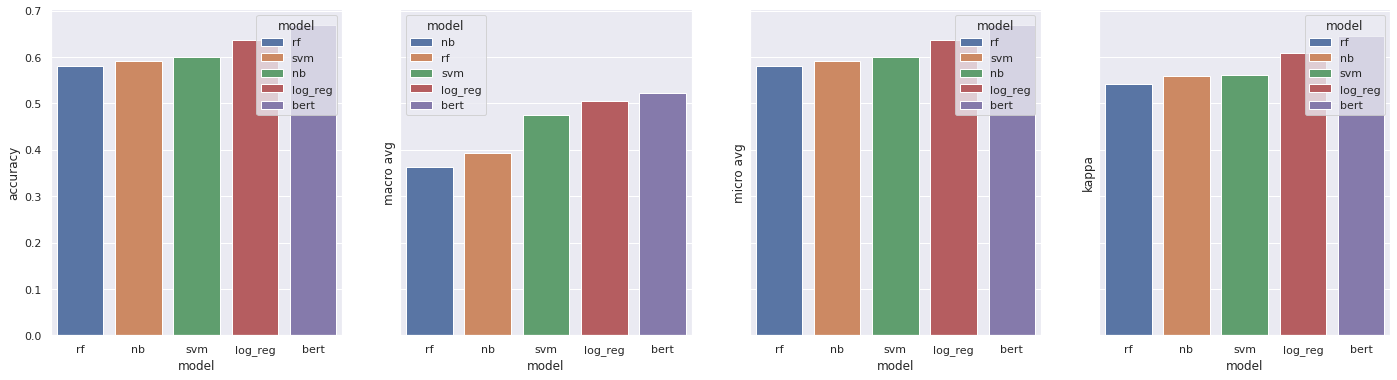

In [ ]:

#sns.set_theme(style="whitegrid")

sns.set(rc={'figure.figsize':(10, 10)})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(24, 6), ncols=4, sharex=True, sharey=True)
sns.barplot(x="model", y="accuracy", hue="model", data=case_1_scores.sort_values(by='accuracy'), ax = ax1, dodge=False)
sns.barplot(x="model", y="macro avg", hue="model", data=case_1_scores.sort_values(by='macro avg'), ax = ax2, dodge=False)
sns.barplot(x="model", y="micro avg", hue="model", data=case_1_scores.sort_values(by='micro avg'), ax = ax3, dodge=False)
sns.barplot(x="model", y="kappa", hue="model", data=case_1_scores.sort_values(by='kappa'), ax = ax4, dodge=False)


plt.show()

## GENERAL VIEW


We can see that the performence of the modesl, and it's scores at the level between **0.35 and 0.68**, the order of the model by the performamce didn't change. Having **random forrest** at the last place, and **BERT** being the best.\

In our training sessions, **BERT**  was the slowest, flowed by **Random forest**, and the rest having slightly the same training time. And supprisinlly, the **Logistic Regression** managed to get a good score given the training time, making it a good model for this case.

From the imbalanced perspective, we can see by comparing the **macro f1 score** of the models, we can find that the random forrest is the most sensitive to the imbalance, then naive bayes, with BERT and logistic regression being the lest affected. Again this prove the supremecy of those two in this task.

In regard to the data, we can see that the size of the class have an effect, the begger classes aee well classed. But that doesn't mean that small classes will be all not well classed, we found that many of them have been well classed. So we theorized that those classes are **specefic** and **decisive** in what they represent. Again we can not have a final judgement until we do the analysis on the case 2.



## DATASET CASE 2 : UNDERSAMPLED BALANCED DATASET


As we have seen the trend in the first dataset prediciton can not be generalazed, until we do some changement on the size of our classes. To see if the theory we put is true or we gonna find more trend. the supposed tracks we can go for to further analyse are :

*   Increase the size of the small not well classified classes, to see if true that these classes are shallow and unspecific, so eather they gonna be get better by having a bigger size, o because they are unspecefic they will stay not well, classified. Sadely, because the dataset is real text by human, we can not create a new synthetic new entries. Nor Oversample,by just duplicate the data, because it will be untrue.
*   Undersample dataset, by taking the same size of each class, so we can see if the big class are well classified thakes to it's size or because they seem to be specific. We don't know so the best to do is to go with the same analysis again and see.



In [ ]:
case_2_dataset = pd.read_csv('DATASETS/case_2_dataset.csv')
print(case_2_dataset.columns)
case_2_data_set_count = get_dataset_count(case_2_dataset)
case_2_data_set_count



Index(['Unnamed: 0', 'category', 'information', 'label'], dtype='object')


,counts,class
FIFTY,1000,FIFTY
DIVORCE,1000,DIVORCE
ARTS & CULTURE,1000,ARTS & CULTURE
STYLE & BEAUTY,1000,STYLE & BEAUTY
PARENTS,1000,PARENTS
GREEN,1000,GREEN
MEDIA,1000,MEDIA
WOMEN,1000,WOMEN
WORLD NEWS,1000,WORLD NEWS
LATINO VOICES,1000,LATINO VOICES


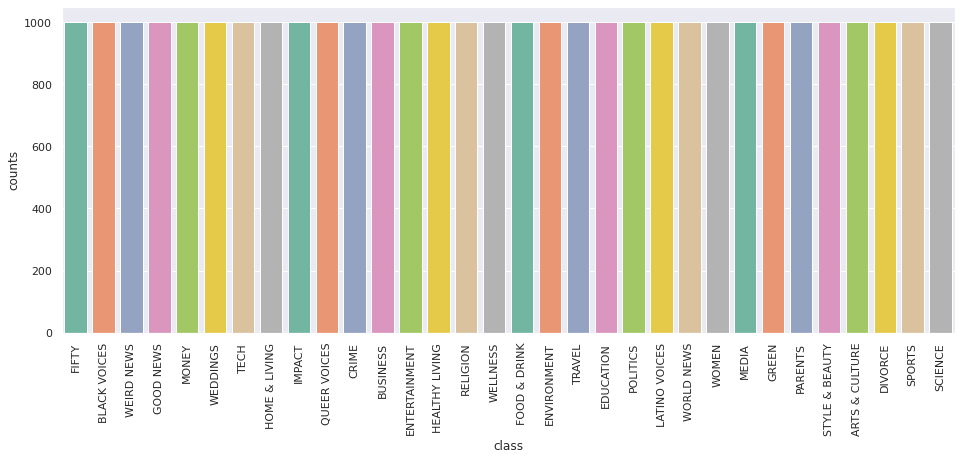

In [ ]:
plot_score(case_2_data_set_count, 'class', 'counts', 'counts', 0)



We choosed to go with 1000 entery by each class, with mean undersapling all classes. This will be more usefull that just undersampling only big classes

## LOGISTIC REGRESSION


again we start by **logistic regression model**, then we will proced with the analysis.

In [84]:
case_2_result_log_reg = get_scores_table('CASE_2/pred_class_case_2_split_1_reg_log.csv')

In [85]:
case_2_result_log_reg

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.516820,0.561462,0.538217,301.000000,ARTS & CULTURE
BLACK VOICES,0.493671,0.534247,0.513158,292.000000,BLACK VOICES
BUSINESS,0.348765,0.375415,0.361600,301.000000,BUSINESS
CRIME,0.590000,0.608247,0.598985,291.000000,CRIME
DIVORCE,0.695238,0.763066,0.727575,287.000000,DIVORCE
EDUCATION,0.656958,0.628483,0.642405,323.000000,EDUCATION
ENTERTAINMENT,0.558642,0.569182,0.563863,318.000000,ENTERTAINMENT
ENVIRONMENT,0.471429,0.597285,0.526946,221.000000,ENVIRONMENT
FIFTY,0.377709,0.432624,0.403306,282.000000,FIFTY
FOOD & DRINK,0.702206,0.513441,0.593168,372.000000,FOOD & DRINK


#### GENERAL VIEW

The first remark is that the overall, score has gone down significantly. witch mean that the size of the classes clearely have an important role in general. Looking at the **accracy** we got **54** a lot less that **64** we got before. But looking at the **macro f1 score** we find that we got the same like th case 1, and supprisingly we got it equal to **micro f1 score**, so we think that the significant attribution of the bigger classes has gone down, so we have the same quality of classification, in indevidual classes, and by reducing the contribution of the weight of the bigger classes. We got the real performance by each class. We will do deeper analysis and see how each class has been classfied.

#### INSIDER VIEW

In [ ]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_2_result_log_reg['counts'] = case_2_data_set_count['counts']
case_2_result_log_reg

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.516820,0.561462,0.538217,301.000000,ARTS & CULTURE,1000.0
BLACK VOICES,0.493671,0.534247,0.513158,292.000000,BLACK VOICES,1000.0
BUSINESS,0.348765,0.375415,0.361600,301.000000,BUSINESS,1000.0
CRIME,0.590000,0.608247,0.598985,291.000000,CRIME,1000.0
DIVORCE,0.695238,0.763066,0.727575,287.000000,DIVORCE,1000.0
EDUCATION,0.656958,0.628483,0.642405,323.000000,EDUCATION,1000.0
ENTERTAINMENT,0.558642,0.569182,0.563863,318.000000,ENTERTAINMENT,1000.0
ENVIRONMENT,0.471429,0.597285,0.526946,221.000000,ENVIRONMENT,1000.0
FIFTY,0.377709,0.432624,0.403306,282.000000,FIFTY,1000.0
FOOD & DRINK,0.702206,0.513441,0.593168,372.000000,FOOD & DRINK,1000.0


[Text(0, 0, 'WEIRD NEWS'),
 Text(0, 0, 'IMPACT'),
 Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'HEALTHY LIVING'),
 Text(0, 0, 'FIFTY'),
 Text(0, 0, 'WELLNESS'),
 Text(0, 0, 'GOOD NEWS'),
 Text(0, 0, 'WOMEN'),
 Text(0, 0, 'GREEN'),
 Text(0, 0, 'SCIENCE'),
 Text(0, 0, 'BLACK VOICES'),
 Text(0, 0, 'PARENTS'),
 Text(0, 0, 'ENVIRONMENT'),
 Text(0, 0, 'ARTS & CULTURE'),
 Text(0, 0, 'POLITICS'),
 Text(0, 0, 'ENTERTAINMENT'),
 Text(0, 0, 'TECH'),
 Text(0, 0, 'WORLD NEWS'),
 Text(0, 0, 'MEDIA'),
 Text(0, 0, 'TRAVEL'),
 Text(0, 0, 'FOOD & DRINK'),
 Text(0, 0, 'STYLE & BEAUTY'),
 Text(0, 0, 'CRIME'),
 Text(0, 0, 'RELIGION'),
 Text(0, 0, 'LATINO VOICES'),
 Text(0, 0, 'MONEY'),
 Text(0, 0, 'EDUCATION'),
 Text(0, 0, 'SPORTS'),
 Text(0, 0, 'QUEER VOICES'),
 Text(0, 0, 'DIVORCE'),
 Text(0, 0, 'HOME & LIVING'),
 Text(0, 0, 'WEDDINGS')]

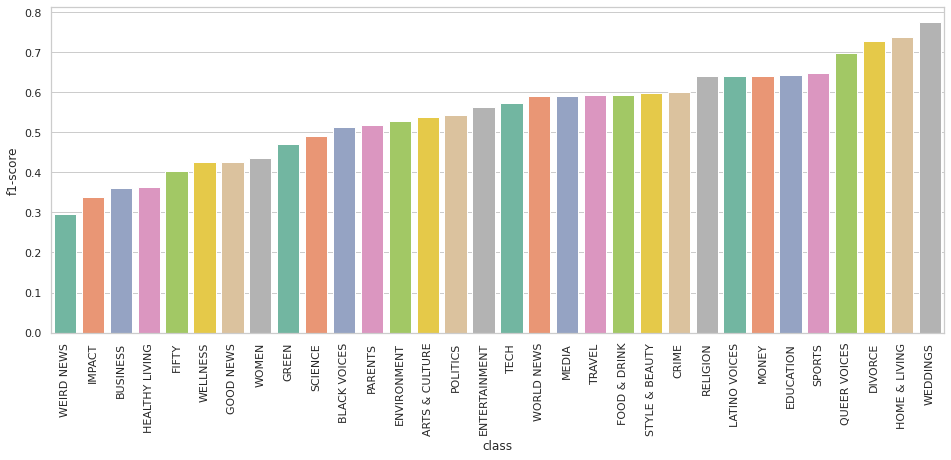

In [ ]:
#sns.set(rc={'figure.figsize':(300, 300)})


sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
g = sns.barplot(x= 'class',y='f1-score', data=case_2_result_log_reg[:-5].sort_values(by='f1-score'), palette = 'Set2')
g.set_xticklabels(g.get_xticklabels(), rotation=90, )

* Like we see, the bigger class got a hit by undersampling, like **Politics**, **Entertainement** this means that the size is a big contributer to their good classification.

* In other hand those samll but peformant classes, still get better classification compared to other, even after undersampling, witch mean that the theory of specifity of the class is the bigger inflowencer of the classification.

In [95]:
case_2_result_log_reg['counts'] = case_1_data_set_count['counts']
case_2_result_log_reg

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.516820,0.561462,0.538217,301.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.493671,0.534247,0.513158,292.000000,BLACK VOICES,4528.0
BUSINESS,0.348765,0.375415,0.361600,301.000000,BUSINESS,5937.0
CRIME,0.590000,0.608247,0.598985,291.000000,CRIME,3405.0
DIVORCE,0.695238,0.763066,0.727575,287.000000,DIVORCE,3426.0
EDUCATION,0.656958,0.628483,0.642405,323.000000,EDUCATION,2148.0
ENTERTAINMENT,0.558642,0.569182,0.563863,318.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.471429,0.597285,0.526946,221.000000,ENVIRONMENT,1323.0
FIFTY,0.377709,0.432624,0.403306,282.000000,FIFTY,1401.0
FOOD & DRINK,0.702206,0.513441,0.593168,372.000000,FOOD & DRINK,8322.0


In [113]:
all_cases = case_1_result_log_reg[:-5].copy()
all_cases = all_cases.append(case_2_result_log_reg[:-5], ignore_index=True )
all_cases.shape

(64, 6)

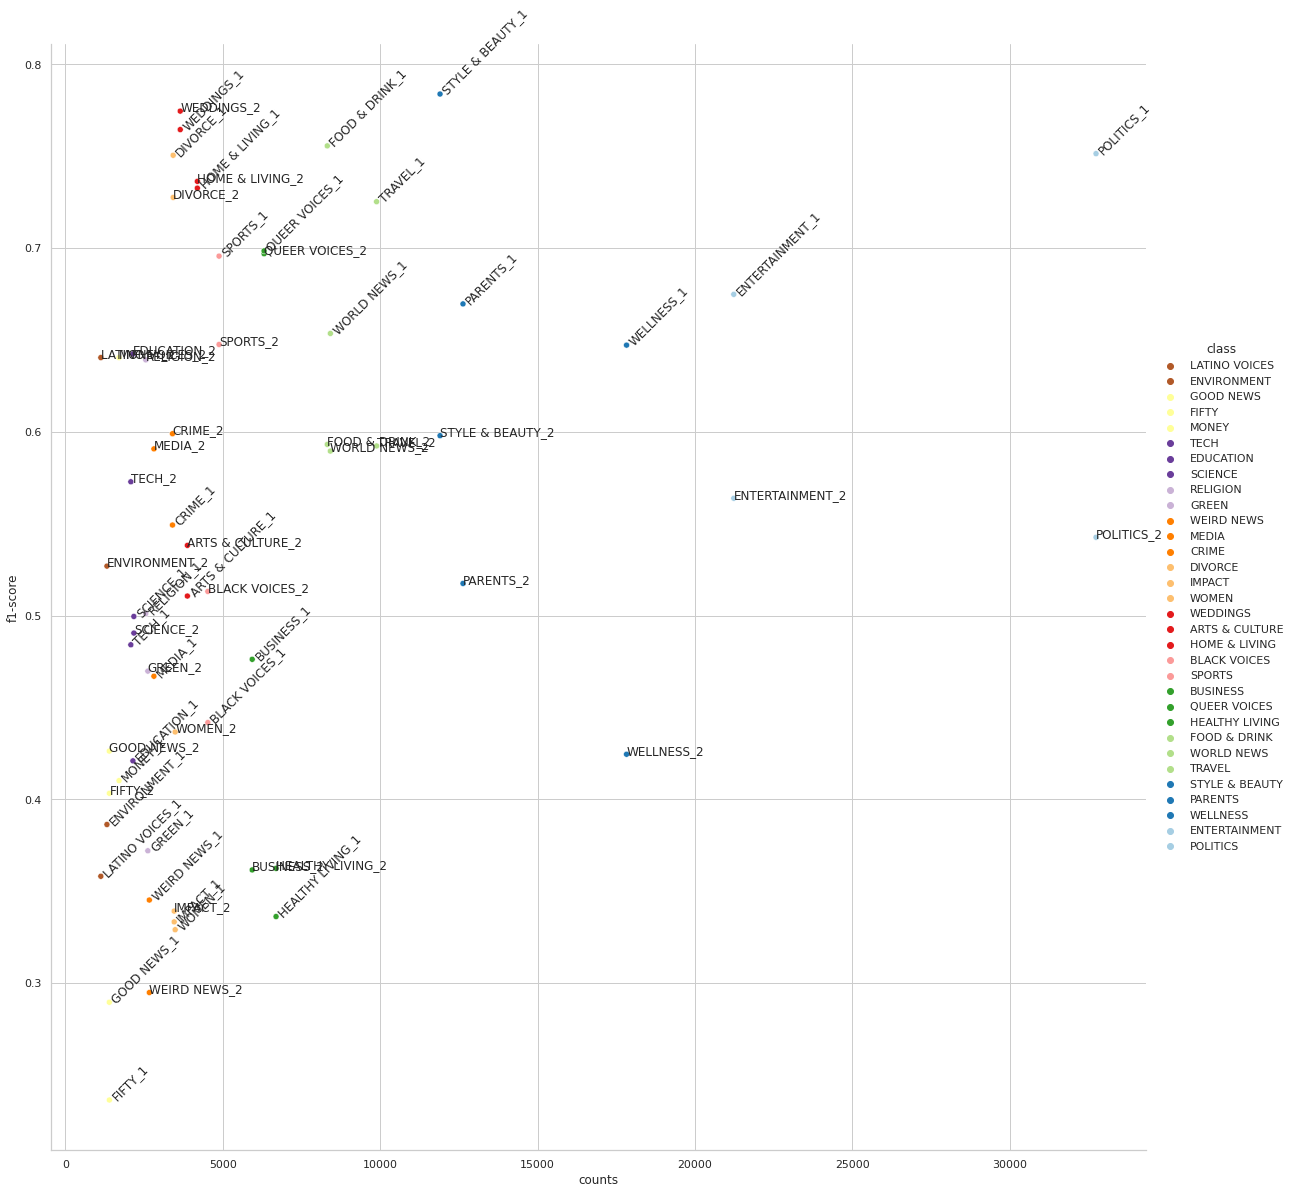

In [121]:
sns.set(style="whitegrid")

p = sns.relplot(x= 'counts', y='f1-score', hue='class', data=all_cases.sort_values(by='counts'), 
            palette='Paired_r', height=16,
            sizes= all_cases['counts'].sort_values() );

ax = p.axes[0,0]
for idx,row in all_cases.iterrows():
    x = row[5]
    y = row[2]
    text = row[4]
    if idx <all_cases.shape[0]/2:
      ax.text(x+.05,y,text+'_1', horizontalalignment='left', rotation=45)
    else:
      ax.text(x+.05,y,text+'_2', horizontalalignment='left', rotation=0)

plt.show()
plt.show()

* As we can see by comparing the **f1 score** between the imbalance and blancing, we generally found the big classer got a big loss in score, but small classes got big  better result, so the size has a big role overall.

* Also the best performing classes, witch we think they are specific, they got a small change in score, by a small loss, or a small gain, so the **specifecity** of the class play a big role overall.

In [122]:
case_2_result_log_reg[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,-0.029669
counts,-0.029669,1.000000


In this case we have a negative correlation, between the sizes and the f1 score, what means that yes, the size have an impact on the classification.

Or the imbalance who have the impact, since we can't oversample, we may not know, we may need another case on this, to be sure.|

In [ ]:
all_cases_bert

## BERT


In order to not wast time, we pass directally to **BERT**, to see it's performence since it did well in case 1

In [123]:
case_2_result_bert = get_scores_table('CASE_2/pred_class_case_2_split_2_bert.csv')

In [124]:
case_2_result_bert

,precision,recall,f1-score,support,class
ARTS & CULTURE,0.636667,0.720755,0.676106,265.000000,ARTS & CULTURE
BLACK VOICES,0.523333,0.640816,0.576147,245.000000,BLACK VOICES
BUSINESS,0.426667,0.528926,0.472325,242.000000,BUSINESS
CRIME,0.696667,0.706081,0.701342,296.000000,CRIME
DIVORCE,0.780000,0.879699,0.826855,266.000000,DIVORCE
EDUCATION,0.690000,0.704082,0.696970,294.000000,EDUCATION
ENTERTAINMENT,0.720000,0.605042,0.657534,357.000000,ENTERTAINMENT
ENVIRONMENT,0.800000,0.714286,0.754717,336.000000,ENVIRONMENT
FIFTY,0.603333,0.651079,0.626298,278.000000,FIFTY
FOOD & DRINK,0.773333,0.738854,0.755700,314.000000,FOOD & DRINK


#### GENERAL VIEW

Supprisingly **BERT** get the best ever score till now in this analysis. By getting over **67** in all metrics. Even in the **macro f1 score** where it got **68** compaired to **67** in **micro f1 score** witch it means that the bias of the classes weight is been over come for this case with BERT. We're not sure but the scores are better. We may need more analysis to know.

Also the reliabilty of the model is over **66** witch make a substantial classifier.

#### INSIDER VIEW

In [125]:
#case_1_resucase_1_result_log_reglt_log_reg[:-5]['f1-score']
case_2_result_bert['counts'] = case_2_data_set_count['counts']
case_2_result_bert

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.636667,0.720755,0.676106,265.000000,ARTS & CULTURE,1000.0
BLACK VOICES,0.523333,0.640816,0.576147,245.000000,BLACK VOICES,1000.0
BUSINESS,0.426667,0.528926,0.472325,242.000000,BUSINESS,1000.0
CRIME,0.696667,0.706081,0.701342,296.000000,CRIME,1000.0
DIVORCE,0.780000,0.879699,0.826855,266.000000,DIVORCE,1000.0
EDUCATION,0.690000,0.704082,0.696970,294.000000,EDUCATION,1000.0
ENTERTAINMENT,0.720000,0.605042,0.657534,357.000000,ENTERTAINMENT,1000.0
ENVIRONMENT,0.800000,0.714286,0.754717,336.000000,ENVIRONMENT,1000.0
FIFTY,0.603333,0.651079,0.626298,278.000000,FIFTY,1000.0
FOOD & DRINK,0.773333,0.738854,0.755700,314.000000,FOOD & DRINK,1000.0


[Text(0, 0, 'WEIRD NEWS'),
 Text(0, 0, 'IMPACT'),
 Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'HEALTHY LIVING'),
 Text(0, 0, 'FIFTY'),
 Text(0, 0, 'WELLNESS'),
 Text(0, 0, 'GOOD NEWS'),
 Text(0, 0, 'WOMEN'),
 Text(0, 0, 'GREEN'),
 Text(0, 0, 'SCIENCE'),
 Text(0, 0, 'BLACK VOICES'),
 Text(0, 0, 'PARENTS'),
 Text(0, 0, 'ENVIRONMENT'),
 Text(0, 0, 'ARTS & CULTURE'),
 Text(0, 0, 'POLITICS'),
 Text(0, 0, 'ENTERTAINMENT'),
 Text(0, 0, 'TECH'),
 Text(0, 0, 'WORLD NEWS'),
 Text(0, 0, 'MEDIA'),
 Text(0, 0, 'TRAVEL'),
 Text(0, 0, 'FOOD & DRINK'),
 Text(0, 0, 'STYLE & BEAUTY'),
 Text(0, 0, 'CRIME'),
 Text(0, 0, 'RELIGION'),
 Text(0, 0, 'LATINO VOICES'),
 Text(0, 0, 'MONEY'),
 Text(0, 0, 'EDUCATION'),
 Text(0, 0, 'SPORTS'),
 Text(0, 0, 'QUEER VOICES'),
 Text(0, 0, 'DIVORCE'),
 Text(0, 0, 'HOME & LIVING'),
 Text(0, 0, 'WEDDINGS')]

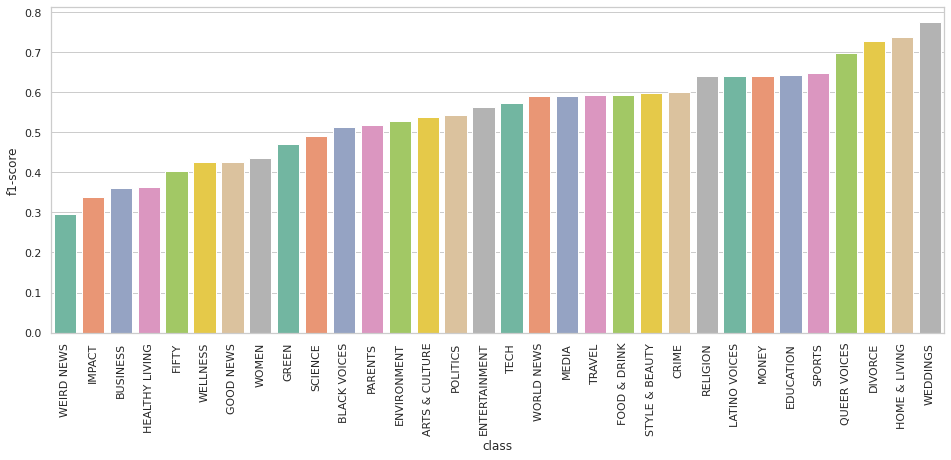

In [126]:
#sns.set(rc={'figure.figsize':(300, 300)})


sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
g = sns.barplot(x= 'class',y='f1-score', data=case_2_result_log_reg[:-5].sort_values(by='f1-score'), palette = 'Set2')
g.set_xticklabels(g.get_xticklabels(), rotation=90, )

We see that the same trend with **logistic regression** is repeated here, where big classes lost score by the undersampling.

And some small classes got better result. We can go and compare the old and new scores to see how undersampling has affected the scores, and the classification.

In [127]:
case_2_result_bert['counts'] = case_1_data_set_count['counts']
case_2_result_bert

,precision,recall,f1-score,support,class,counts
ARTS & CULTURE,0.636667,0.720755,0.676106,265.000000,ARTS & CULTURE,3878.0
BLACK VOICES,0.523333,0.640816,0.576147,245.000000,BLACK VOICES,4528.0
BUSINESS,0.426667,0.528926,0.472325,242.000000,BUSINESS,5937.0
CRIME,0.696667,0.706081,0.701342,296.000000,CRIME,3405.0
DIVORCE,0.780000,0.879699,0.826855,266.000000,DIVORCE,3426.0
EDUCATION,0.690000,0.704082,0.696970,294.000000,EDUCATION,2148.0
ENTERTAINMENT,0.720000,0.605042,0.657534,357.000000,ENTERTAINMENT,21233.0
ENVIRONMENT,0.800000,0.714286,0.754717,336.000000,ENVIRONMENT,1323.0
FIFTY,0.603333,0.651079,0.626298,278.000000,FIFTY,1401.0
FOOD & DRINK,0.773333,0.738854,0.755700,314.000000,FOOD & DRINK,8322.0


In [128]:
all_cases_bert = case_1_result_bert[:-5].copy()
all_cases_bert = all_cases_bert.append(case_2_result_bert[:-5], ignore_index=True )
all_cases_bert.shape

(64, 6)

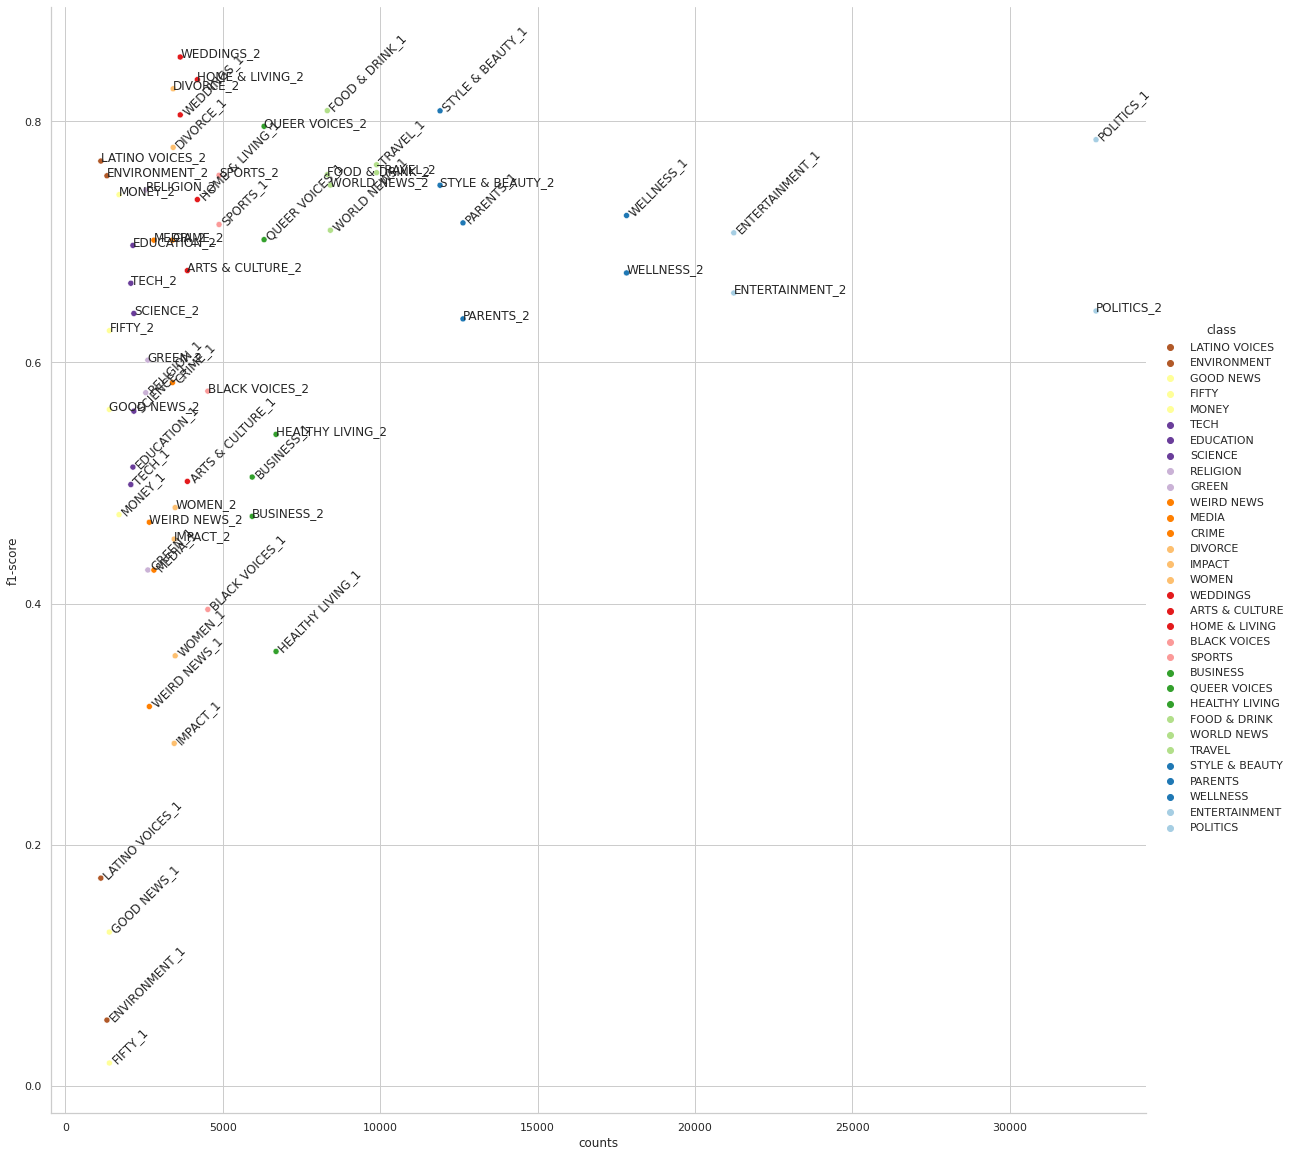

In [130]:
sns.set(style="whitegrid")

p = sns.relplot(x= 'counts', y='f1-score', hue='class', data=all_cases_bert.sort_values(by='counts'), 
            palette='Paired_r', height=16,
            sizes= all_cases_bert['counts'].sort_values() );

ax = p.axes[0,0]
for idx,row in all_cases_bert.iterrows():
    x = row[5]
    y = row[2]
    text = row[4]
    if idx <all_cases_bert.shape[0]/2:
      ax.text(x+.05,y,text+'_1', horizontalalignment='left', rotation=45)
    else:
      ax.text(x+.05,y,text+'_2', horizontalalignment='left', rotation=0)

plt.show()
plt.show()

* As we can see by comparing the **f1 score** between the imbalance and blancing, we generally found the big classer got a big loss in score, but small classes got big  better result, so the size has a big role overall.

* Also the best performing classes, witch we think they are specific, they got a small change in score, by a small loss, or a small gain, so the **specifecity** of the class play a big role overall.

* Even the less specified classes a goost in score. This mean that BERT has better result with balanced data.

In [131]:
case_2_result_bert[['f1-score', 'counts']][:-5].corr()


,f1-score,counts
f1-score,1.000000,-0.001025
counts,-0.001025,1.000000


In this case we have a negative correlation, between the sizes and the f1 score, what means that yes, the size have an impact on the classification.

Or the imbalance who have the impact, since we can't oversample, we may not know, we may need another case on this, to be sure.|

## FINAL COMPARISION OF CASE 2



In [ ]:
#!pip install seaborn==0.11.0



In [132]:
case_2_result_nb = get_scores_table('CASE_2/pred_class_case_2_split_1_nb.csv')
case_2_result_svm = get_scores_table('CASE_2/pred_class_case_2_split_1_svm.csv')
case_2_result_rf = get_scores_table('CASE_2/pred_class_case_2_split_1_rf.csv')

preparing the final scores tables.

In [133]:
case_2_scores = case_2_result_log_reg[-5:].transpose().head(0)

case_2_scores = add_model_to_case(case_2_scores, case_2_result_log_reg, 5, 'log_reg')
case_2_scores = add_model_to_case(case_2_scores, case_2_result_nb, 5, 'nb')
case_2_scores = add_model_to_case(case_2_scores, case_2_result_svm, 5, 'svm')
case_2_scores = add_model_to_case(case_2_scores, case_2_result_rf, 5, 'rf')
case_2_scores = add_model_to_case(case_2_scores, case_2_result_bert, 5, 'bert')

case_2_scores

,accuracy,macro avg,weighted avg,micro avg,kappa,model
0,0.543438,0.546128,0.545623,0.543438,0.528696,log_reg
0,0.533229,0.536565,0.57425,0.533229,0.518177,nb
0,0.49875,0.50191,0.502475,0.49875,0.482568,svm
0,0.484271,0.486643,0.517705,0.484271,0.46756,rf
0,0.672396,0.672396,0.674684,0.672396,0.661828,bert


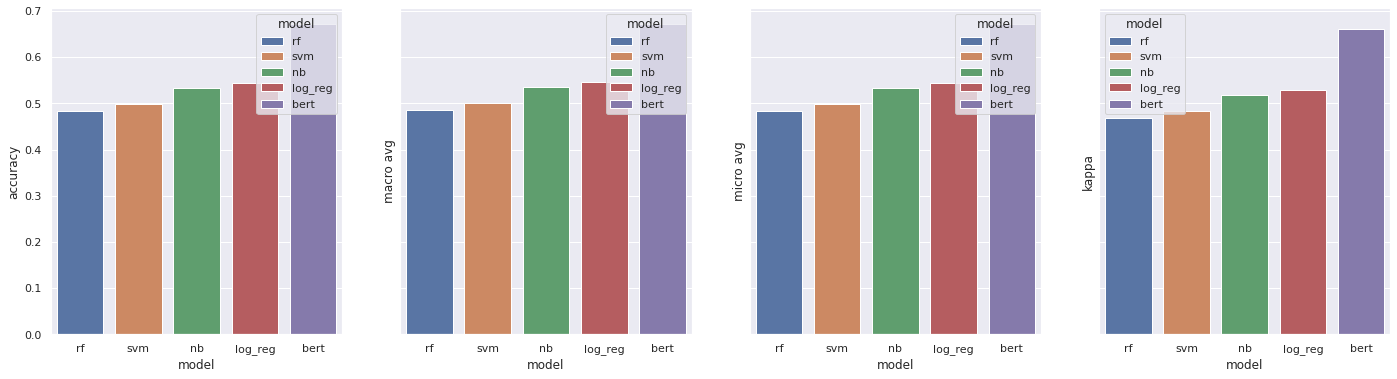

In [134]:

#sns.set_theme(style="whitegrid")

sns.set(rc={'figure.figsize':(10, 10)})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(24, 6), ncols=4, sharex=True, sharey=True)
sns.barplot(x="model", y="accuracy", hue="model", data=case_2_scores.sort_values(by='accuracy'), ax = ax1, dodge=False)
sns.barplot(x="model", y="macro avg", hue="model", data=case_2_scores.sort_values(by='macro avg'), ax = ax2, dodge=False)
sns.barplot(x="model", y="micro avg", hue="model", data=case_2_scores.sort_values(by='micro avg'), ax = ax3, dodge=False)
sns.barplot(x="model", y="kappa", hue="model", data=case_2_scores.sort_values(by='kappa'), ax = ax4, dodge=False)


plt.show()

## GENERAL VIEW


* We can see that the models got less score at accuracy but better scores at **macro f1 score**, exept **BERT** who got even better values. The order still the same, at the top there is BERT and Logistic regression.

* In this case **Naive Bayes** has outperforme **SVM** ant take the third place, but **Random forrest** still at the end of the list.

* In our training sessions also, **BERT**  was the slowest, flowed by **Random forest**, and the rest having slightly the same training time. And the **Logistic Regression** still faster but is the margine is lower now from the models under it.

In [138]:
all_cases_score = case_2_scores.copy()
all_cases_score['case'] = ['case_2']*5

case_1_inter = case_1_scores.copy()
case_1_inter['case'] = ['case_1']*5

all_cases_score = all_cases_score.append(case_1_inter)
all_cases_score

,accuracy,macro avg,weighted avg,micro avg,kappa,model,case
0,0.543438,0.546128,0.545623,0.543438,0.528696,log_reg,case_2
0,0.533229,0.536565,0.57425,0.533229,0.518177,nb,case_2
0,0.49875,0.50191,0.502475,0.49875,0.482568,svm,case_2
0,0.484271,0.486643,0.517705,0.484271,0.46756,rf,case_2
0,0.672396,0.672396,0.674684,0.672396,0.661828,bert,case_2
0,0.637696,0.504324,0.660645,0.637696,0.60879,log_reg,case_1
0,0.598961,0.36357,0.751555,0.598961,0.559988,nb,case_1
0,0.591941,0.47456,0.600162,0.591941,0.561346,svm,case_1
0,0.579876,0.392805,0.659933,0.579876,0.541795,rf,case_1
0,0.669516,0.522643,0.705504,0.669516,0.644356,bert,case_1


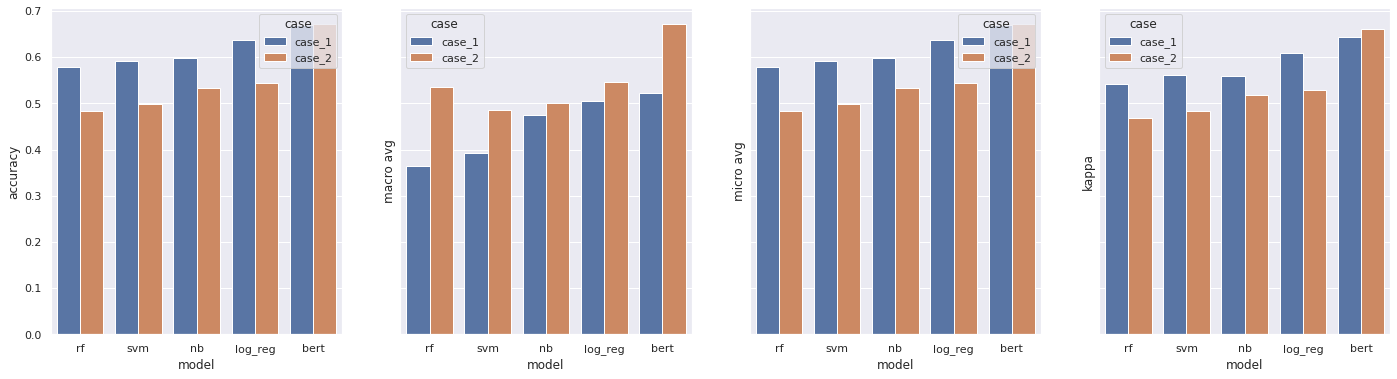

In [147]:
sns.set(rc={'figure.figsize':(10, 10)})
case_order = ['case_1', 'case_2']
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(24, 6), ncols=4, sharex=True, sharey=True)
sns.barplot(x="model", y="accuracy", hue="case",hue_order=case_order, data=all_cases_score.sort_values(by='accuracy'), ax = ax1)
sns.barplot(x="model", y="macro avg", hue="case",hue_order=case_order, data=all_cases_score.sort_values(by='macro avg'), ax = ax2)
sns.barplot(x="model", y="micro avg", hue="case",hue_order=case_order, data=all_cases_score.sort_values(by='micro avg'), ax = ax3)
sns.barplot(x="model", y="kappa", hue="case",hue_order=case_order, data=all_cases_score.sort_values(by='kappa'), ax = ax4)


plt.show()

As we can see, from the point of view of the **cases**,  the performence between the **cases** differ from the metric to the other depending on the model.

* For the **accuracy**, all the models got higher scores in the case imbalanced data, compared to balanced case2.

* Same thing with **micro f1 score**, all models got better score in this metrics for case 1 but less for case 2.

* But for the **macro f1 score** things changed, the models got better scores for case 2 than case 1. Some models got a big jump like **Random Forrest** and **BERT**.

* But the real diffrence happer here where all models got better scores at case 1, but only **BERT** who got better score in this score. But BERT had already a the best score.

from the point of models, we can see some consistancy, at least for the order of performance of the model, where the order is **BERT, LOGISTIC EGRESSION, NAIVE BAYSE, SUPPORT VECTOR MACHINE, and RANDOM FORREST**. 

* The models scores variate from a metric to the other, for all model execpt **BERT** who kept showing the same score for all metrics except one time where it got lower **macro f1 score at case 1**.

* In general all model got better score at case 1 except of **macro f1 score** and except **BERT**.



* In general, the models work fine in the case 1, at the cost of undermining small and non specific class, witch is fine when you don't care about those classes.

* For the magority of the models, the score drop significantly for some metics, and for the bigger class in the case of balancing the data.

* **BERT** proved to be reliable in the 2 cases, epecially, when we balanced the data, **BERT** didn't lower the quality of classification for the bigger classses, and also imporoved the classification of small and shallow classses.

We can say that for a production scenario **BERT** model is a good choice for classifying these news articles.